# 5. Neural Networks

### *Table of Contents*

* 5.1 [Feed-forward Network Functions](#5.1-Feed-forward-Network-Functions)
* 5.2 [Network Training](#5.2-Network-Training)
    * 5.2.1 [Parameter optimization](#5.2.1-Parameter-optimization)
    * 5.2.2 [Local quadratic approximation](#5.2.2-Local-quadratic-approximation)
    * 5.2.4 [Gradient descent optimization](#5.2.4-Gradient-descent-optimization)
* 5.3 [Error Backpropagation](#5.3-Error-Backpropagation)
* 5.5 [Regularization in Neural Networks](#5.5-Regularization-in-Neural-Networks)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from prml import nn
from prml.linear import Perceptron, LogisticRegression 
from prml.datasets import (
    generate_toy_data,
    load_planar_dataset, 
    plot_2d_decision_boundary
)


# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%reload_ext autoreload
%autoreload 2

## 5.1 Feed-forward Network Functions

The linear models discussed in previous chapters are based on linear combinations of fixed (non)linear basis functions $\phi_j(\mathbf{x})$ and take the form,

$$
y(\mathbf{x},\mathbf{w}) = f\Bigg(\sum_{j=1}^M w_j\phi_j(\mathbf{x})\Bigg)
$$

where $f(\cdot)$ is a nonlinear activation function in the case of classification and the identity in the case of regression. Although such models have useful analytical properties, they are limited by the curse of dimentionality, and they need to adapt the basis functions to the data for large-scale problems. An alternative is to use a predefined number of basis functions but allow them to be adaptive during training. Thus, an extension of the model above is making the basis functions $\phi_j(\mathbf{x})$ depend on parameters and then adjust them along the coefficients $\{w_j\}$, during training.

*Neural networks* use basis functions that follow the same form, that is, each basis function is itself a nonlinear function of a linear combination of the inputs, where the coefficients are adapative parameters. Thus, the basic neural network model is described as a series of functional transformations.

1. Given the input variables $x_1,\dots,x_D$, we construct $M$ linear combinations in the form:

$$
a_j = \sum_{i=1}^D w_{ji}^{(1)}x_i + w_{j0}^{(1)}
$$

where $j=1,\dots,M$, and the superscript $(1)$ indicates the corresponding parameters of the *first* layer of the network. The input layer often uses the superscript $(0)$. The quantities $a_j$ are known as activations and each of them is transformed using a *differentiable* nonlinear activation function $h(\cdot)$ to give

$$
z_j = h(a_j)
$$

these correspond to the outputs of the basis functions, and in the context of neural networks are called *hidden units*. The following figure presents the two step computation of a single unit or neuron.

<img src="../images/neuron.png" width=500 height=250>
<!-- ![Neuron](../images/neuron.png) -->

2. Following the same procedure, these output values from the *first* layer, are linearly combined again to give,

$$
a_k = \sum_{j=1}^M w_{ki}^{(2)}z_j + w_{k0}^{(2)}
$$

where $k=1,\dots,K$. This transformation corresponds to the *second* layer of the network. These output activations are transformed again using an appropriate activation function $h$ to give a set of outputs $y_k$. The following figure depicts the entire process for a $2$-layer network.

> It is called a $2$-layer neural network because there are two layers of adaptive weights.

<img src="../images/fg5_1.png" width=500 height=250>
<!-- ![NeuralNet](../images/fg5_1.png) -->

The output unit activation function is determined by the nature of the data and the assumed distribution of target variables. Thus, for regression problems, the activation function can be the **identity**, so that $y_k=\alpha_k$, and for classification, the output uses a **sigmoid, or softmax** function, so that $y_k=\sigma(\alpha_k)$.

We may combine these stages to obtain the overall network function (using a sigmoid output unit), as follows,

$$
y_k(\mathbf{x},\mathbf{w}) = \sigma\Bigg(\sum_{j=1}^M w_{kj}^{(2)}h\Bigg(\sum_{i=1}^D w_{ji}^{(1)}x_i + w_{j0}^{(1)}\Bigg) + w_{k0}^{(2)} \Bigg)
$$

where biases on each layer can be absorbed into the set of weight parameters by defining an additional input variable $x_0=1$.

**Important Notes:**

* The **key difference** compared to the perceptron is that the neural network uses continuous sigmoidal non-linear hidden units, whereas the perceptron uses step-function non-linearities. This means that the neural network function is differentiable which plays a central role in network training.


* If the activation functions of all hidden units are taken to be linear, then any such network can be replaced by a network without the hidden units. This follows from the fact that the composition of successive linear transformations is itself a linear transformation.

In order to study these claims, lets consider a dataset, in which, the classes are separated by a non-linear decision boundary. Therefore, a simple linear model, without performing any sophisticated feature engineering, cannot capture.

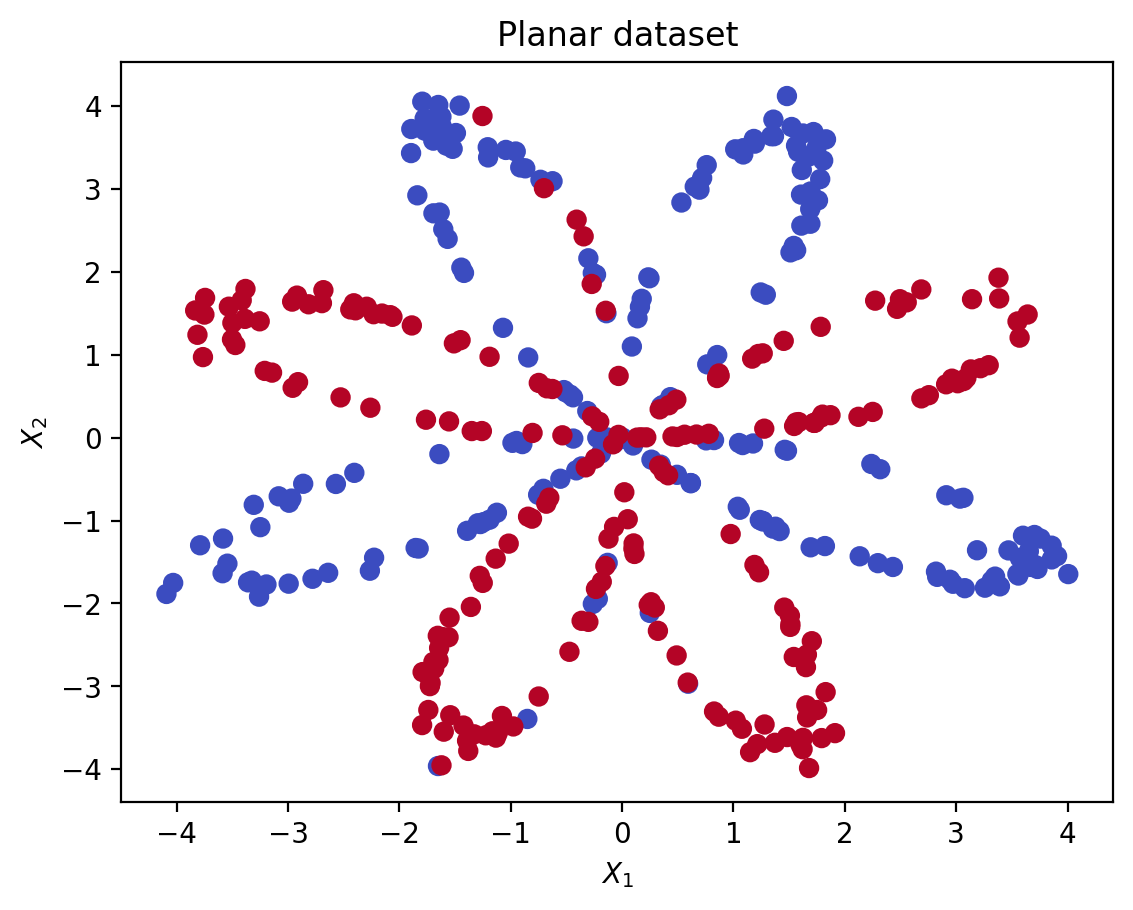

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
We have 400 training examples!


In [3]:
x, y = load_planar_dataset()
plt.scatter(x[0, :], x[1, :], c=y, s=40, cmap=plt.cm.coolwarm)
plt.title("Planar dataset")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

print(f"The shape of X is: {str(x.shape)}")
print(f"The shape of Y is: {str(y.shape)}")
print(f"We have {x.shape[1]} training examples!")

Training either a simple perceptron or a logistic regression classifier, similar to the ones presented in [Chapter 4](ch4_linear_models_for_classification.ipynb), only manages to learn an insufficient linear decision boundary that cannot capture the underlying data distribution.

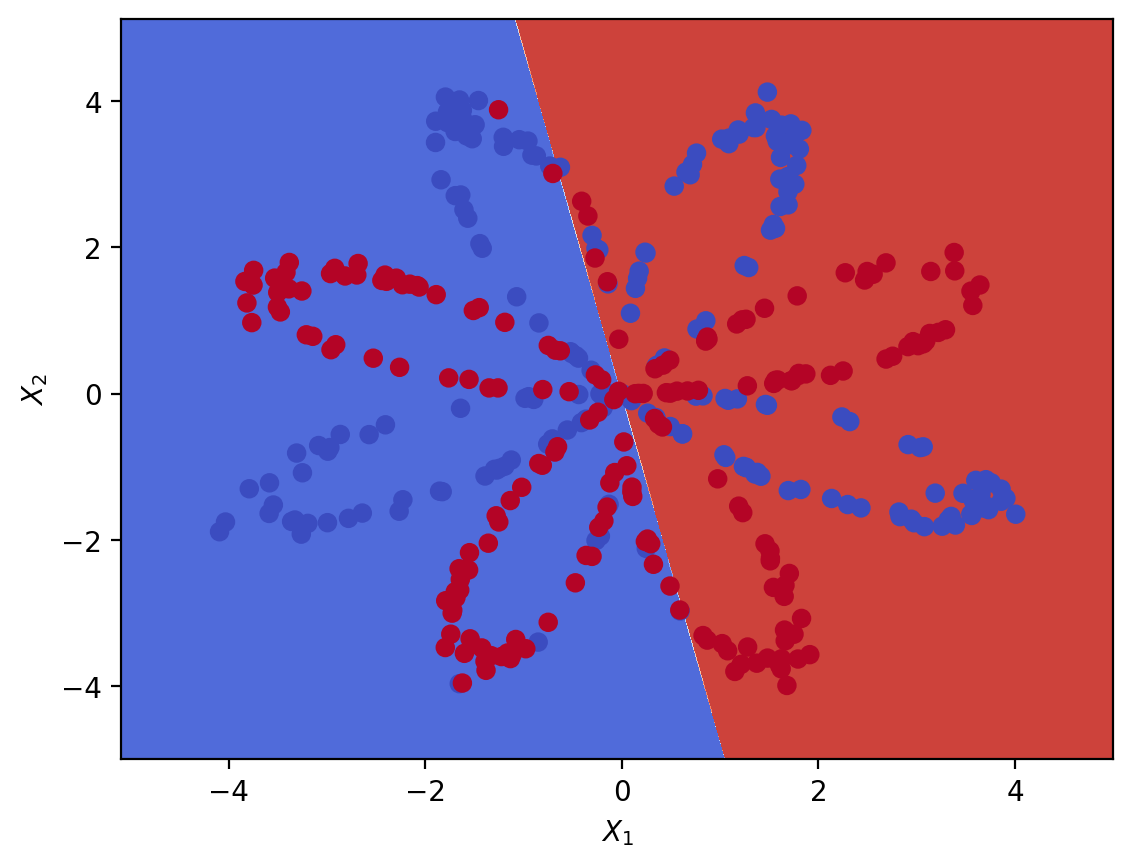

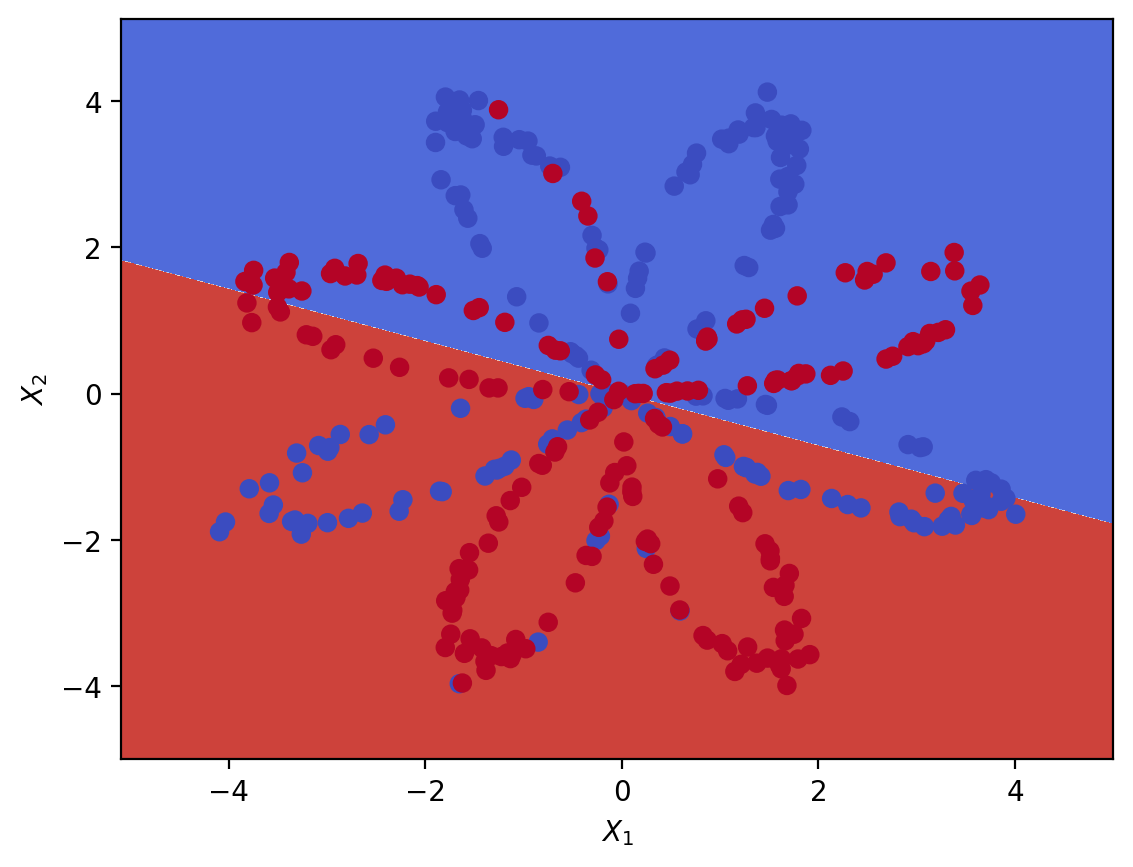

In [4]:
classifier = Perceptron()
classifier.fit(x.T, np.squeeze(y))
plot_2d_decision_boundary(lambda x: classifier.predict(x.T) > 0.5, x, y)

classifier = LogisticRegression()
classifier.fit(x.T, np.squeeze(y))
plot_2d_decision_boundary(lambda x: classifier.predict(x.T) > 0.5, x, y)

### Linear Algebra Notation

For efficiency reasons, in an actual implementation, its more convinient to represent the activations in some $\ell$-layer as an $M$-dimensional vector,

$$
\mathbf{a}^{(\ell)} = 
\begin{bmatrix}
a_1^{(\ell)} \\
a_2^{(\ell)} \\
\vdots \\
a_M^{(\ell)} 
\end{bmatrix} =
\begin{bmatrix}
\mathbf{w}_{1}^{(\ell)T}\mathbf{z}^{(\ell-1)} + w_{10}^{(\ell)} \\
\mathbf{w}_{2}^{(\ell)T}\mathbf{z}^{(\ell-1)} + w_{20}^{(\ell)} \\
\vdots \\
\mathbf{w}_{M}^{(\ell)T}\mathbf{z}^{(\ell-1)} + w_{M0}^{(\ell)} \\
\end{bmatrix} =
\begin{bmatrix}
\mathbf{w}_{1}^{(\ell)T} \\
\mathbf{w}_{2}^{(\ell)T} \\
\vdots \\
\mathbf{w}_{M}^{(\ell)T} \\
\end{bmatrix} \mathbf{z}^{(\ell-1)} + \mathbf{w}_{0}^{(\ell)} =
\mathbf{W}^{(\ell)}\mathbf{z}^{(\ell-1)} + \mathbf{w}_{0}^{(\ell)}
$$

In terms of matrix dimensions, we have $(M \times D) (D \times 1) + (M \times 1)$. Then, the activation function $h(\cdot)$ is applied on $\mathbf{a}^{(\ell)}$ to obtain,

$$
\mathbf{z}^{(\ell)} = h^{(\ell)}(\mathbf{a}^{(\ell)})
$$

This can also be generalized across $N$ training examples $\mathbf{x}_i$, by stacking them in columns, creating a matrix $\mathbf{X}$ of dimensions $(D \times N)$. Then, we obtain,

$$
\mathbf{W}^{(\ell)}\mathbf{Z}^{(\ell-1)} + \mathbf{w}_{0}^{(\ell)}
$$

and

$$
\mathbf{Z}^{(\ell)} = h^{(\ell)}(\mathbf{A}^{(\ell)})
$$

where $\mathbf{Z}^{(0)} = \mathbf{X}$.

### Activation Functions

In the general case, we can use as an activation function any non-linear $h(\mathbf{z})$. Some popular choices are the following non-linear functions.

1. The sigmoid function or $\sigma(z) = \frac{1}{1 + e^{-z}}$. Mostly used in the output layer for representing class probability. In the case of multi-class problems, the softmax activation function is used instead of the sigmoid.


2. The hyperbolic tangent or $\mathrm{tanh}(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$. Note that the hyperbolic tangent is a shifted version of the sigmoid function, that crosses zero point and rescales so that it ranges from $-1$ to $1$. That means that it has the effect of centering the data around zero which is a desired property for learning algorithms.

> However, a downside of both the sigmoid and the hyperbolic tangent is that as $z$ gets very large or very small the slope of the function gets close to zero thus slowing down gradient descent.


3. The rectified linear unit or $\mathrm{relu}(z) = \max(0, z)$. Thus, the derivative is $1$ as long as $z>0$ and $0$ when $z\leq0$.


4. The leaky rectified linear unit or $\mathrm{leaky relu}(z) = \max(0.01z, z)$, attempts to improves upon the dying ReLU problem, which is that all negative input values become zero immediately. Another variation is the parametric ReLU, which simply makes $0.01$ a parameter, i.e., $\max(\alpha z, z)$.

Rectified linear unit actication functions, overcome the problem of vanishing gradients, and thus, they enable much faster training of neural networks.


5. The exponential linear unit (ELU) or $\mathrm{elu}(z) = \begin{cases} z & \quad z \geq 0 \\ \alpha(e^z -1 ) & \quad z < 0 \end{cases}$ uses a log curve to define the negative values unlike the parametric ReLU functions that use a straight line.


6. The self-gated activation function (Swish) or $\mathrm{swish}(z) = z\sigma(z)$ is a smooth function that does not abruptly change direction $x = 0$. Rather, it smoothly bends from 0 towards values < 0 and then upwards again. It consistently matches or outperforms the ReLU activation functions. 

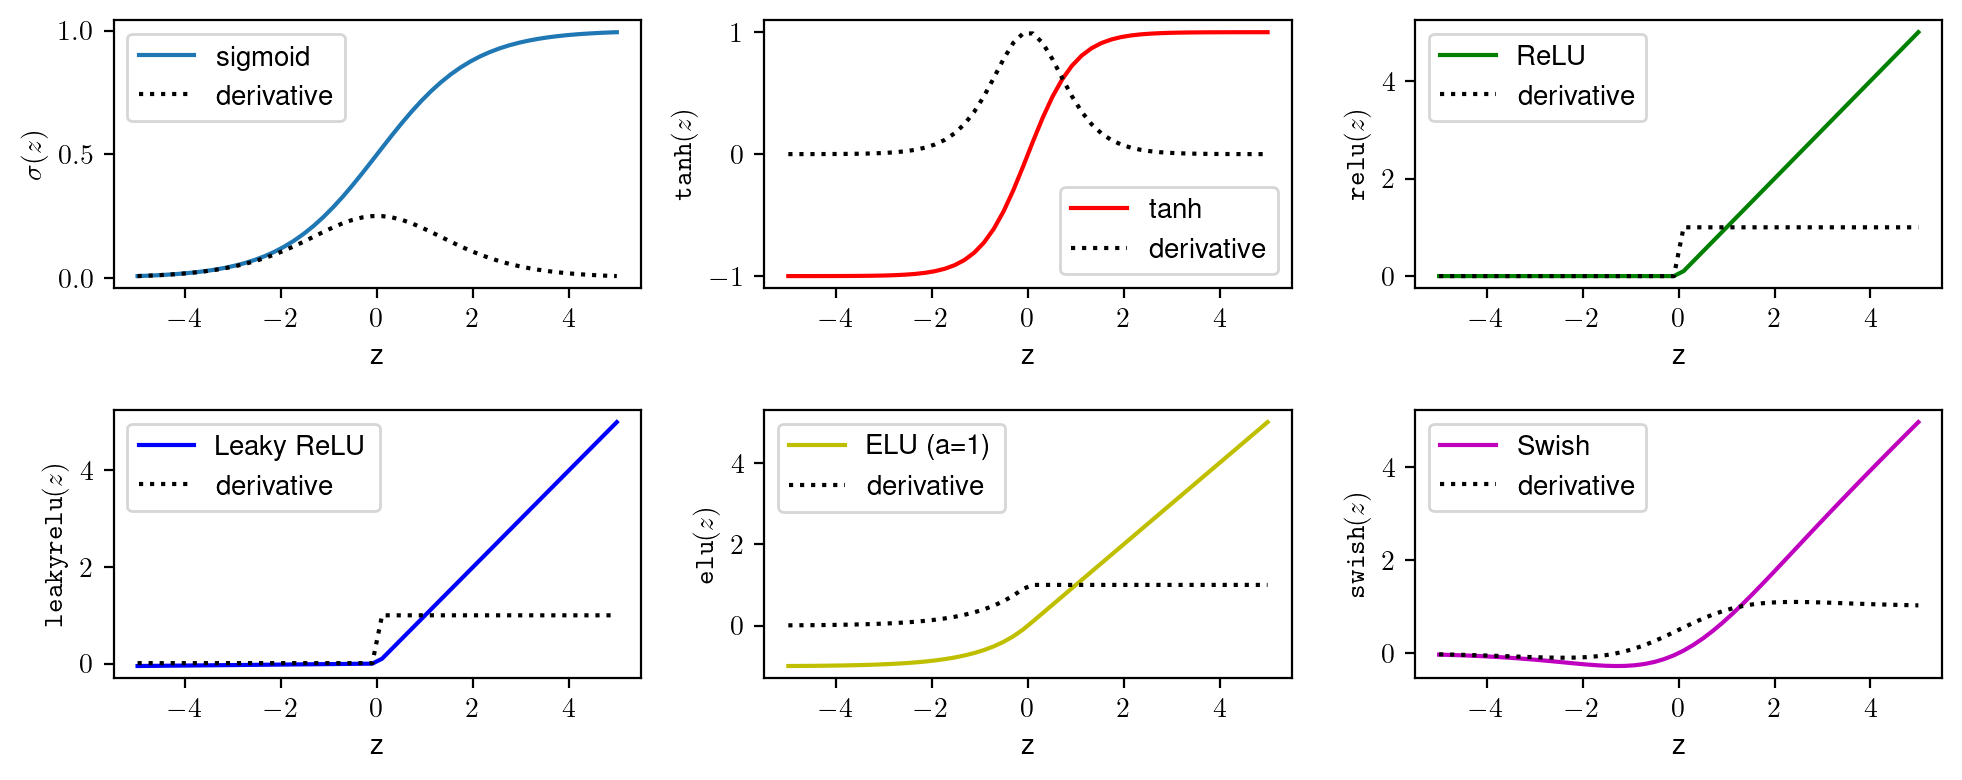

In [92]:
import math
import numpy as np

def sigmoid(z: np.ndarray) -> float:
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5)

plt.figure(figsize=(10, 4))

plt.subplot(2, 3, 1)
plt.tight_layout()
plt.plot(z, sigmoid(z))
plt.plot(z, sigmoid(z)*(1 - sigmoid(z)), 'k', linestyle='dotted')
plt.xlabel("z")
plt.ylabel("$\sigma(z)$")
plt.legend(['sigmoid', 'derivative'])

plt.subplot(2, 3, 2)
plt.tight_layout()
plt.plot(z, np.tanh(z), 'r')
plt.plot(z, 1 - np.tanh(z)*np.tanh(z), 'k', linestyle='dotted')
plt.xlabel("z")
plt.ylabel("$\mathtt{tanh}(z)$")
plt.legend(['tanh', 'derivative'])

plt.subplot(2, 3, 3)
plt.tight_layout()
plt.plot(z, np.maximum(0, z), 'g')
plt.plot(z, np.where(z > 0, 1, 0), 'k', linestyle='dotted')
plt.xlabel("z")
plt.ylabel("$\mathtt{relu}(z)$")
plt.legend(['ReLU', 'derivative'])

plt.subplot(2, 3, 4)
plt.tight_layout()
plt.plot(z, np.maximum(0.01*z, z), 'b')
plt.plot(z, np.where(z > 0, 1, 0.01), 'k', linestyle='dotted')
plt.xlabel("z")
plt.ylabel("$\mathtt{leakyrelu}(z)$")
plt.legend(['Leaky ReLU', 'derivative'])

plt.subplot(2, 3, 5)
plt.tight_layout()
plt.plot(z, np.where(z > 0, z, np.exp(z) - 1), 'y')
plt.plot(z, np.where(z > 0, 1, np.where(z > 0, z, np.exp(z) - 1) + 1), 'k', linestyle='dotted')
plt.xlabel("z")
plt.ylabel("$\mathtt{elu}(z)$")
plt.legend(['ELU (a=1)', 'derivative'])

plt.subplot(2, 3, 6)
plt.tight_layout()
plt.plot(z, z * sigmoid(z), 'm')
plt.plot(z, sigmoid(z) + z*sigmoid(z)*(1 - sigmoid(z)), 'k', linestyle='dotted')
plt.xlabel("z")
plt.ylabel("$\mathtt{swish}(z)$")
plt.legend(['Swish', 'derivative'])

plt.show()

## 5.2 Network Training

###### Regression

A simple approach to the problem of determining the network parameters is to revisit the discussion of polynomial curve fitting, and attempt to minimize a sum-of-squares error function. Thus, given a training set comprising a set of input vectors $\{\mathbf{x}_n\}$, where $n=1,\dots,N$, and a corresponding set of target vectors $\{\mathbf{t}_n\}$, we minimize the error function,

$$
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N ||\mathbf{y}(\mathbf{x}_n, \mathbf{w}) - \mathbf{t}_n)||^2
$$

Consider regression problems, and for the moment, a single target variable $t$ that may take any real value. Similar to Section 3.1, we assume that $t$ follows a Gaussian distribution having an $\mathbf{x}$-dependent mean, which is given by the output of the neural network,

$$
p(t|\mathbf{x},\mathbf{w}) = \mathcal{N}(t|y(\mathbf{x},\mathbf{w}),\beta^{-1})
$$

For the above conditional distribution, it is sufficient to take the output unit activation function to be the identity, because such a network can approximate any continuous function from $\mathbf{x}$ to y. Given a data set of $N$ independent, identically distributed observations $\mathbf{X}$, and the corresponding target values $\mathsf{t}$, the likelihood function is as follows,

$$
p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) = \prod_{n=1}^N p(t_n|\mathbf{x}_n,\mathbf{w},\beta) = \prod_{n=1}^N \mathcal{N}(t_n|y(\mathbf{x}_n,\mathbf{w}),\beta^{-1})
$$

Then, by taking the negative logarithm, we obtain the same error function derived in (3.11). By minimizing the error function, we obtain the maximum likelihood solution $\mathbf{w}_{ML}$. Having found $\mathbf{w}_{ML}$, the value of $\beta$ can be found using (3.21), derived by minimizing the negative log likelihood.

> **IMPORTANT:** Keep in mind, however, that the nonlinearity of the network function $y(\mathbf{x}_n,\mathbf{w})$ causes the error to be nonconvex, and so a local maxima of the likelihood may be found, corresponding to local minima of the error function.

###### Classification

In binary classification a single target variable $t$ such that $t=1$ for class $\mathcal{C}_1$ and $t=0$ for class $\mathcal{C}_2$. We consider a network having a single output whose activation function is a logistic sigmoid,

$$
y = \sigma(\alpha) = \frac{1}{1 + \exp(-\alpha)}
$$

so that $0 \leq y(\mathbf{x},\mathbf{w}) \leq 1$, is interpreted as the conditional probability $p(\mathcal{C}_k|\mathbf{x})$ given by $1 - y(\mathbf{x},\mathbf{w})$. The conditional distribution of targets given inputs is then a Bernoulli distribution of the form,

$$
p(t|\mathbf{x},\mathbf{w}) = y(\mathbf{x},\mathbf{w})^t\{1-y(\mathbf{x},\mathbf{w})\}^{1-t}
$$

Given a training set of independent observations, the the error function by the negative log-likelihood, if the *cross-entropy* error function of the form,

$$
E(\mathbf{w}) = -\sum_{n=1}^N \{t_n\ln y_n + (1-t_n)\ln(1-y_n)\}
$$

> **NOTE**: There is no analogue of the noise precision $\beta$ because the target values are assumed to be correctly labelled.

> **IMPORTANT**: There is a natural choice of both output unit activation function and matching error function, according to the type of problem being solved. For regression we rely on linear outputs and sum-of-squares error, and for binary logistic sigmoid (binary) or softmax (multiclass) outputs and cross-entropy error function.

### 5.2.1 Parameter optimization

The goal is to find a vector such that $E(\mathbf{w})$ is minimized. However, the error function has a highly nonlinear dependence on the weights, and so there are many points in the weight space at which the gradient vanishes. Since there is no hope of finding an analytical solution to the equation $\nabla E(\mathbf{w})=0$ we resort to iterative numerical procedures. Most of these techniques involve choosing an initial value $\mathbf{w}^{(0)}$ for the weight vector and then moving through weight space in a succession of steps of the form,

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} + \Delta\mathbf{w}^{(\tau)}
$$

Such algorithms involve different choices for the weight vector update $\Delta\mathbf{w}^{(\tau)}$. Usually, they make use of gradient information and therefore require that, after each update, the value of $\nabla E(\mathbf{w})$ is evaluated at the updated weight vector $\mathbf{w}^{(\tau+1)}$. In order to understand the importance of gradient information, it is useful to consider a local approximation to the error function based on a Taylor expansion.

### 5.2.2 Local quadratic approximation

Consider the second-order Taylor expansion of $E(\mathbf{w})$ around some point $\hat{\mathbf{w}}$,

$$
E(\mathbf{w}) \approx E(\hat{\mathbf{w}}) +(\mathbf{w} - \hat{\mathbf{w}})^T\mathbf{b} + \frac{1}{2}(\mathbf{w} - \hat{\mathbf{w}})^T\mathbf{H}(\mathbf{w} - \hat{\mathbf{w}})
$$

where $\mathbf{b}=\nabla E|_{\mathbf{w}=\hat{\mathbf{w}}}$ and $\mathbf{H}=\nabla\nabla E$ is the Hessian matrix of second derivatives. Thus, the local approximation to the gradient is given by,

$$
E(\mathbf{w}) \approx \mathbf{b} + \mathbf{H}(\mathbf{w} - \hat{\mathbf{w}})
$$

for points $\mathbf{w}$ that are sufficiently close to $\hat{\mathbf{w}}$, these expressions give reasonable approximations for the error and its gradient.

Consider, for instance, a simple 2-dimensional error function of the form $E(w_1, w_2) = w_1^2 + w_2^4 + w_1w_2$.

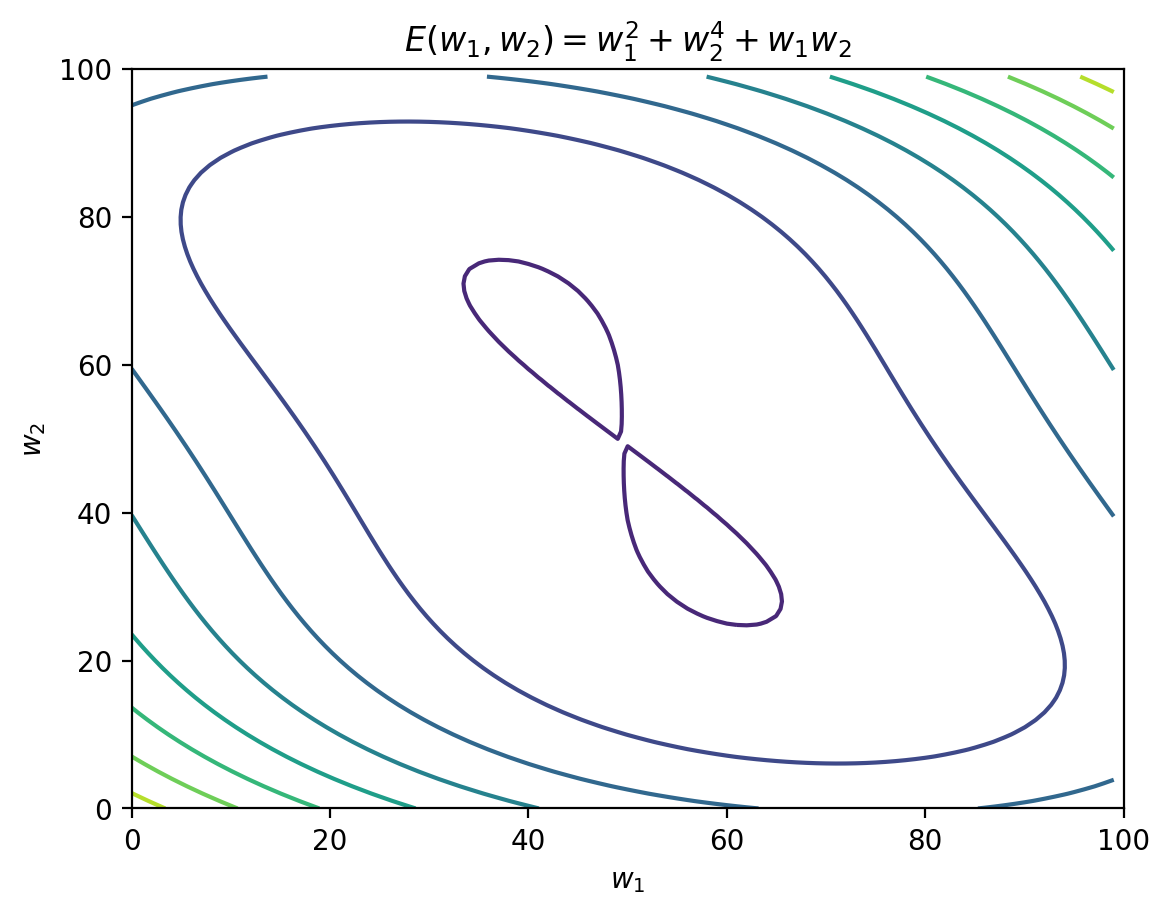

In [13]:
w = np.linspace(-1, 1, 100)
w1, w2 = np.meshgrid(w, w)

def E(w1: float, w2: float) -> float:
    return w1**2 + w2**4 + w1 * w2

plt.contour(w1**2 + w2**4 + w1 * w2)
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("$E(w_1, w_2) = w_1^2 + w_2^4 + w_1w_2$")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

The gradient of $E(w_1, w_2)$ is defined as follows,

$$
\nabla E = 
\begin{bmatrix}
\frac{\partial E}{w_1} \\[0.1cm]
\frac{\partial E}{w_2}
\end{bmatrix} =
\begin{bmatrix}
2w_1 + w_2 \\[0.1cm]
4w_2 + w_1
\end{bmatrix}
$$

and the Hessian matrix $\mathbf{H}$ equals,

$$
\mathbf{H} = \nabla\nabla E = 
\begin{bmatrix}
\frac{\partial E}{w_1w_1} & \frac{\partial E}{w_1w_2} \\[0.1cm]
\frac{\partial E}{w_2w_1} & \frac{\partial E}{w_2w_2}
\end{bmatrix} =
\begin{bmatrix}
2 & 1 \\[0.1cm]
1 & 4
\end{bmatrix}
$$

In [14]:
def gradient(w1, w2):
    return np.array([2*w1 + w2, 4*w2 + w1])

H = np.array([[2,1],[1,4]])

Then, given some point $\hat{\mathbf{w}} = [\hat{w}_1, \hat{w}_2]$, $E(w_1, w_2)$ can be approximated by,

$$
E(w_1, w_2) \approx E(\hat{w_1}, \hat{w_2}) + [w_1 - \hat{w_1}, w_2 - \hat{w_2}]
\begin{bmatrix}
2\hat{w_1} + \hat{w_2} \\[0.1cm]
4\hat{w_2} + \hat{w_1}
\end{bmatrix} +
\frac{1}{2} [w_1 - \hat{w_1}, w_2 - \hat{w_2}]^T 
\begin{bmatrix}
2 & 1 \\[0.1cm]
1 & 4
\end{bmatrix}
[w_1 - \hat{w_1}, w_2 - \hat{w_2}]
$$

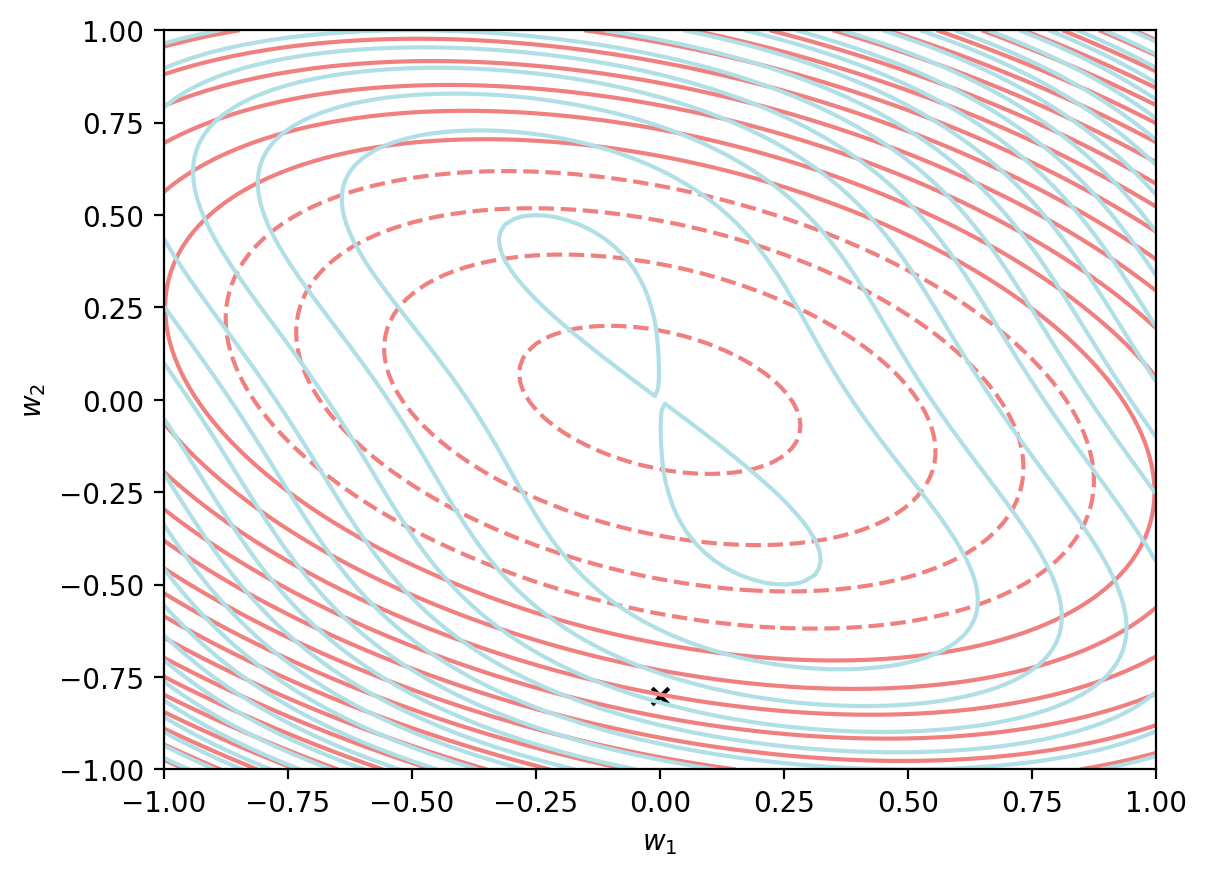

In [17]:
w_hat= np.array([0, -0.8])

@np.vectorize
def E_approx(w1, w2):
    w = np.array([w1, w2])
    return E(*w_hat) + np.dot((w - w_hat), gradient(*w_hat)).T + 0.5 * np.dot(w - w_hat, np.dot(H, w - w_hat))
    
plt.contour(w1, w2, E_approx(w1, w2), 20, colors='lightcoral')
plt.contour(w1, w2, E(w1, w2), 20, colors='powderblue')
plt.scatter(*w_hat, color="black", marker="x")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.show()

### 5.2.4 Gradient descent optimization

The simplest approach to using gradient information is to choose the weight update to be a small step in the direction of the negative gradient, so that,

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta\nabla E(\mathbf{w}^{(\tau)})
$$

where the parameter $\eta > 0$ is known as *learning rate*. At each step the weight vector is moved in the direction of the greatest rate of decrease of the error function, and so the approach is known as *gradient descent* or *steepest descent*. Note that the error function is defined with respect to a training set, and thus, each step requires that the entire training set be processed in order to evaluate $\nabla E$. Techniques that use the whole data set at once are called *batch* methods. Although such an approach might intuitively seem reasonable, in fact it turns out to be a poor algorithm.

For *batch optimization*, there are more efficient methods, such as conjugate gradients and quasi-Newton methods, which are much more robust and much faster than simple gradient descent. Unlike gradient descent, these algorithms have the property that the error function always decreases at each iteration unless the weight vector has arrived at a local or global minimum.

There is, however, an on-line version of gradient descent, known as *sequential gradient descent* or *stochastic gradient descent*, that has proved useful in practice for training neural networks on large data sets. Error functions based on maximum likelihood for a set of independent observations comprise a sum of terms, one for each data point,

$$
E(\mathbf{w}) = \sum_{n=1}^N E_n(\mathbf{w})
$$

Stochastic gradient descent makes an update to the weight vector based on **one data point** at a time, so that

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta\nabla E_n(\mathbf{w}^{(\tau)})
$$

The update is repeated by cycling through the data either in sequence or by selecting points at random with replacement. There are of course intermediate scenarios in which the updates are based on batches of data points. One advantage of on-line methods compared to batch methods is that the former handle redundancy in the data much more efficiently. To see, this consider an extreme example in which we take a data set and double its size by duplicating every data point. Note that this simply multiplies the error function by a factor of $2$ and so is equivalent to using the original error function. Batch methods will require double the computational effort to evaluate the batch error function gradient, whereas online methods will be unaffected. Another property of on-line gradient descent is the possibility of escaping from local minima, since a stationary point with respect to the error function for the whole data set will generally not be a stationary point for each data point individually.

## 5.3 Error Backpropagation

Error backpropagation, or simply backprop, is an efficient technique for evaluating the gradient of an error function $E(\mathbf{w})$ for a feed-forward neural net. This can be achieved using a local message passing scheme in which information is sent alternately forwards and backwards through the network.

Most training algorithms involve an iterative procedure for minimization of an error function. At each such step, we can distinguish between two stages:

1. The derivatives of the error function must be evaluated. The important contribution of the backpropagation technique is in providing a computationally efficient method for evaluating such derivatives. Since the errors are propagated backwards through the network, we use the term backpropagation to describe the evaluation of derivatives. 


2. The derivatives are then used to compute the adjustments to be made to the weights, e.g., gradient descent. 

It is important to recognize that these stages are distinct. Thus, the first stage, namely the propagation of errors backwards through the network in order to evaluate derivatives, can be applied to many other kinds of networks and not just the multilayer perceptron. It can also be applied to error functions other than the simple sum-of-squares, and to the evaluation of other derivatives, such as, the Jacobian and Hessian matrices.

### 5.3.1 Evaluation of error-function derivatives

The backpropagation algorithm can be applied to a general network of arbitrary topology, non-linear activation functions, and a broad class of error function. Many error functions of practical interest comprise a sum of terms, one of each data point, so that,

$$
E(\mathbf{w}) = \sum_{n=1}^N E_n(\mathbf{w})
$$

For simplicity, consider the evalution of a single term $\nabla E_n(\mathbf{w})$. Consider the first linear model, where the outputs are linear combinations of the input variables.

$$
y_{nk} = y_k(\mathbf{x}_n, \mathbf{w}) = \sum_i w_{ki}x_i
$$

thus, the error function for input example $n$, takes the form,

$$
E_n = \frac{1}{2} \sum_k(y_{nk} - t_{nk})^2
$$

and its gradient with respect to $w_{ji}$, is given by,

$$
\frac{\partial E_n}{\partial w_{ji}} = (y_{nj} - t_{nj})x_{ni}
$$

In a general feed-forward network, each unit $j$ (in any layer $\ell$) computes a weighted sum of its inputs, as follows,

$$
a_j = \sum_i  w_{ji}z_i
$$

where $z_i$ is the activation of a unit in the previous layer ($\ell-1$), that sends a connection to unit $j$, and $w_{ji}$ is the weight associated with the connection. Then, the sum $a_j$ is transformed by a non-linear activation function $h(\cdot)$ to give $z_j$ in the form,

$$
z_j = h(a_j)
$$

In turn, $z_j$ may be sent as a connection to a subsequent unit in order to participate in another activation. Note that using the vectorized notation introduced in the beginning of this chapter, we can compute the transformed activations of any layer $\ell$ as follows,

$$
\begin{align}
\mathbf{a}^{\ell} &= \mathbf{W}^{\ell}\mathbf{z}^{\ell-1} \\
\mathbf{z}^{\ell} &= h(\mathbf{a}^{\ell})
\end{align}
$$


In order to apply backprop, we assume that we have computed the activations of all hidden and output units in the network, a process called *forward propagation* because it may be regarded as the forward flow of information through the network. Consider again the evaluation of the derivative $E_n$. Given an arbitraty unit $j$, $E_n$ depends on the weight $w_{ji}$ only via the input $a_j$. Therefore, according to the chain rule for partial derivatives, we obtain,

$$
\frac{\partial E_n}{\partial w_{ji}} = \frac{\partial E_n}{\partial a_j} \frac{\partial a_j}{\partial w_{ji}} \overset{(5.48)}= \frac{\partial E_n}{\partial a_j} z_i
$$

Since $z_i$ is computed during forward propagation, we only need to compute $\frac{\partial E_n}{\partial a_j}$. For simplicity, lets define $\delta_j = \frac{\partial E_n}{\partial a_j}$.

1. For the output units, we have that $\delta_k = \frac{\partial E_n}{\partial y_k} \overset{(5.46)}= y_k - t_k$.

2. For hidden units, we apply again the chain rule,

$$
\begin{align}
\delta_j &= \frac{\partial E_n}{\partial a_j} = \sum_k \frac{\partial E_n}{\partial a_k} \frac{\partial a_k}{\partial a_j} \\ 
&= \sum_k \delta_k \frac{\partial a_k}{\partial a_j} \overset{(5.48)}= \sum_k \delta_k \Big( \frac{\partial}{\partial a_j} \sum_j w_{kj} z_j \Big) \overset{(5.49)}= \sum_k \delta_k \Big( \frac{\partial}{\partial a_j} \sum_j w_{kj} h(a_j) \Big) \\
&= h'(a_j) \sum_k w_{kj} \delta_k
\end{align}
$$

where the sum runs over all $k$ units to which $j$ sends connections. Thus, for a particular hidden unit, $\delta$ is obtained by propagating the $\delta$ backwards from units higher up in the network.

<img src="../images/fg5_7.png" width=500 height=250>
<!-- ![Backprop](../images/fg5_7.png) -->

Since, we know the $\delta$ for the output units, we can recursively evaluate the $\delta$ for all the hidden units in a feed-forward neural net, regardless of the topology.

**Error Backpropagation algorithm**

1. Forward propagate any input vector $\mathbf{x}_n$ using $(5.48)$ and $(5.49)$.

2. Evalute $\delta_k$ for output units using $(5.54)$.

3. Backpropagate $\delta$ using $(5.56)$ to obtain $\delta_j$ for each hidden unit.

4. Evalute the required derivatives using $(5.53)$.

For batch methods, the derivative of the total error $E$ is obtained be repeating the above steps for each example $n$ and then summing over all examples.

### Implementation notes

When implementing neural networks is much more performant to perform forward and backward propagation using the matrix notation introduced in the beginning of this chapter. Therefore, here we present both propagations in matrix notation across multiple training examples.

**Forward Propagation**

1. $\mathbf{Z}^{(0)} = \mathbf{X}$

2. Repeat for each layer $\ell$: 
    - $\mathbf{Z}^{(\ell)} = \mathbf{W}^{(\ell)}\mathbf{Z}^{(\ell-1)} + \mathbf{w}_{0}^{(\ell)}$ 
    - and $\mathbf{Z}^{(\ell)} = h^{(\ell)}(\mathbf{A}^{(\ell)})$

**Backward Propagation**

1. For the output layer evalute $\boldsymbol\delta^{L} = \mathbf{y} - \mathtt{t}$

2. Backpropagate $\boldsymbol\delta^{\ell+1}$ to obtain $\boldsymbol\delta^{\ell} = h'(\mathbf{a}^{\ell}) \odot \big( \mathbf{W}^{(\ell+1)T} \boldsymbol\delta^{\ell+1} \big)$

3. Evaluate derivatives $\nabla E_n(\mathbf{W}^{\ell}) = \boldsymbol\delta^{\ell}\mathbf{z}^{\ell-1}$

Let's train a shallow $2$-layer neural network for classification, on the planar dataset, using one hidden layer of hyperbolic tangent activation functions and one sigmoid output layer. In order to train the network for classification, we use a cross-entropy loss function, similar to logistic regression. The weights of the neural network are initialized at random, while biases are initialized to zero values.

Cost after iteration 0: 0.6931468220962944
Cost after iteration 1000: 0.3688472333755473
Cost after iteration 2000: 0.25523300251664954
Cost after iteration 3000: 0.23332205977141876
Cost after iteration 4000: 0.2226010338988146
Cost after iteration 5000: 0.21576502656465416
Cost after iteration 6000: 0.21083595640954933
Cost after iteration 7000: 0.2070202913264673
Cost after iteration 8000: 0.20392605876420533
Cost after iteration 9000: 0.20133285138931697


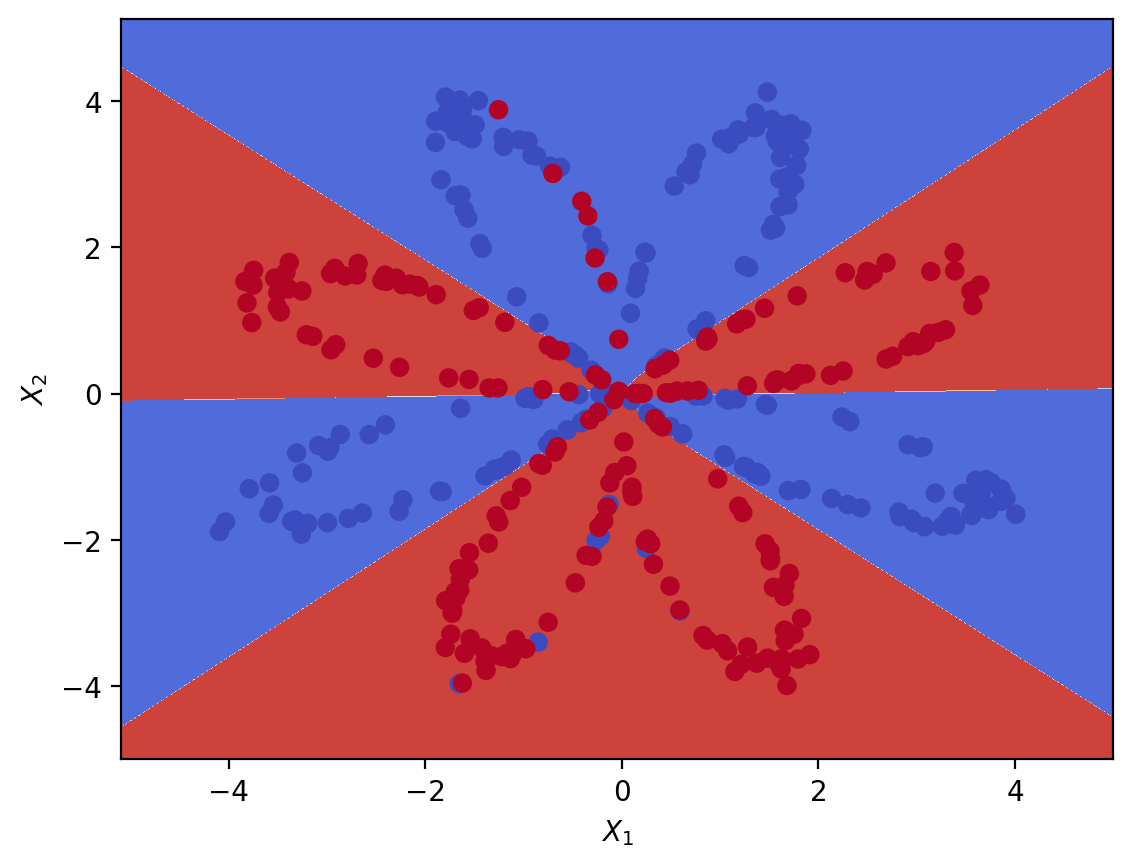

In [5]:
net = nn.NeuralNetwork(
    nn.LinearLayer(2, 4),
    nn.TanH(),
    nn.LinearLayer(4, 1),
    nn.Sigmoid(),
)

L = nn.CrossEntropyLoss()
net.fit(x, y, loss=L)
plot_2d_decision_boundary(lambda x: net.predict(x) > 0.5, x, y)

##### What happens if all weights and biases are initialized to the same value?

Then all hidden units are symmetric (completely identical), thus computing the same function, which is undesirable. Therefore, weights must be initialized randomly. Biases can still be zero since they represent a single dimension in the weight vectors of the hidden units which already differ due to the random initialization. As a proof of concept, lets re-train the same exact network but initialize weights and bias to a constant value.

Cost after iteration 0: 0.693312419347396
Cost after iteration 1000: 0.6320299205818806
Cost after iteration 2000: 0.6239224334603003
Cost after iteration 3000: 0.6209061832412387
Cost after iteration 4000: 0.6192287736354253
Cost after iteration 5000: 0.6181185729625578
Cost after iteration 6000: 0.6173089891564346
Cost after iteration 7000: 0.6166813047335402
Cost after iteration 8000: 0.6161738193400937
Cost after iteration 9000: 0.6157509051403725


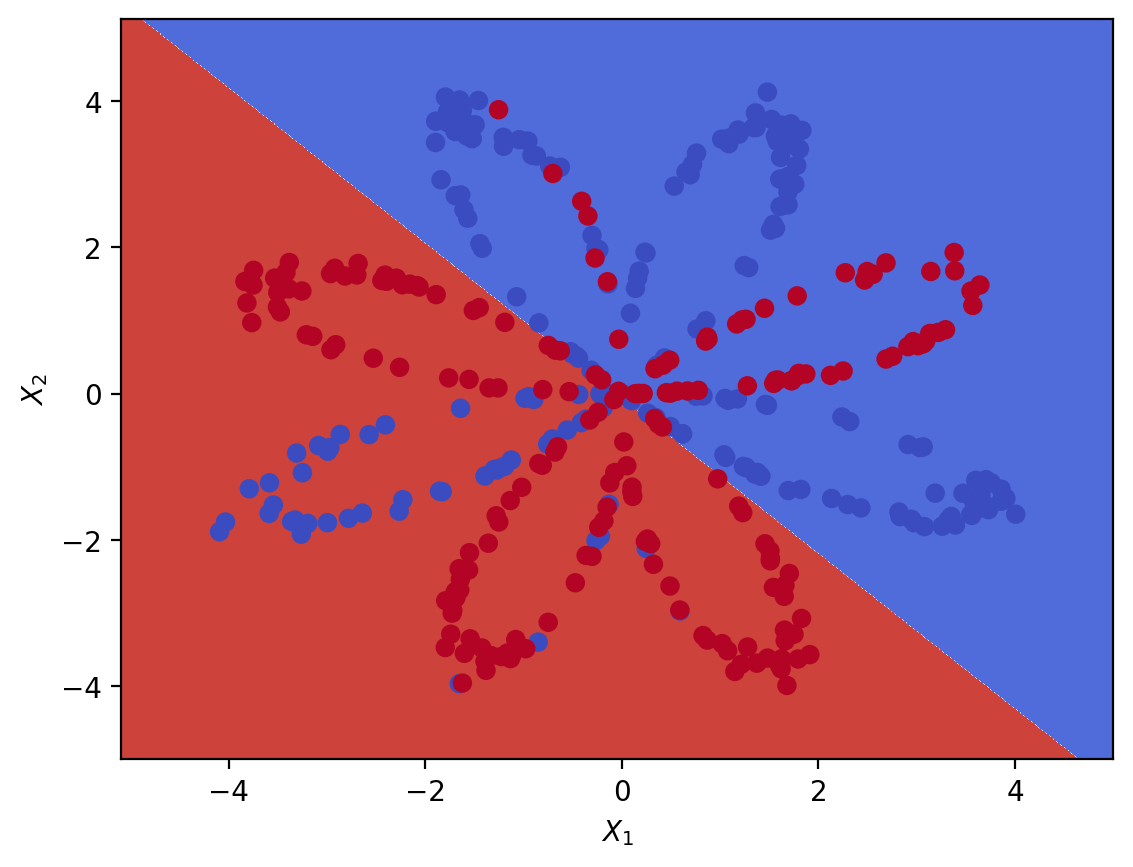

In [14]:
net = nn.NeuralNetwork(
    nn.LinearLayer(2, 4, random_initialization=False),
    nn.TanH(),
    nn.LinearLayer(4, 1, random_initialization=False),
    nn.Sigmoid(),
)

L = nn.CrossEntropyLoss()
net.fit(x, y, loss=L)
plot_2d_decision_boundary(lambda x: net.predict(x) > 0.5, x, y)

Note that the behavior of the trained network is identical to logistic regression and the perceptron models we used in the beginning of the chapter.

## 5.5 Regularization in Neural Network

The number $M$ of hidden units if a free parameter, in contrast to input and output units, and can be adjusted to obtain the best predictive performance. Note that $M$ indirectly controls the number of parameters (weights and biases) in the network, and therefore, we expect that by using maximum likelihood, we should find an optimal value for $M$ that yields the best generalization performance, corresponding to the optimal balance between an under-fit and over-fit.

The generalization error, however, is not a simple function of $M$ due to the presence of local minima in the error function. One approach of choosing $M$ is to plot a graph of $M$ against validation set performance and then choose the solution having the smallest validation set error, similar to model selection on [Chapter 1](ch1_introduction.ipynb).

Another approach of course is to choose a relatively large value for $M$ and add a regularization term to the error function in order to control the model complexity. The simplest regularizer is the quadratic, also known as *weight decay* in the context of neural networks,

$$
\tilde{E}(\mathbf{w}) = E(\mathbf{w}) + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w}
$$

The effective model complexity is then determined by the choice of $\lambda$. As discussed in [Chapter 1](ch1_introduction.ipynb), the quadratic regularizer can be interpreted as the negative logarithm of a zero-mean Gaussian prior over the weight vector $\mathbf{w}$. Then, adding a quadratic regularization term, the error function for input example $n$, takes the form,

$$
\tilde{E}_n = \frac{1}{2} \sum_k(y_{nk} - t_{nk})^2 + \frac{\lambda}{2}\sum_{k=1}w_k^2
$$

and the gradient is obtained as follows:

$$
\frac{\partial \tilde{E}_n}{w_{ji}} = (y_{nj} - t_{nj})x_{ni} + \lambda w_j = \frac{\partial E_n}{w_{ji}} + \lambda w_j
$$

or

$$
\nabla \tilde{E}_n = (\mathbf{y}_n - \mathbf{t}_n)\mathbf{x}_n + \lambda\mathbf{w} = \nabla E_n + \lambda\mathbf{w}
$$

Then, by replacing back into $(5.43)$, the stochastic gradient descent update becomes:

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta\Big(\nabla E_n(\mathbf{w}^{(\tau)}) + \lambda\mathbf{w}^{(\tau)} \Big)
= \mathbf{w}^{(\tau)} - \eta\nabla E_n(\mathbf{w}^{(\tau)}) - \eta\lambda\mathbf{w}^{(\tau)}
= (1 - \eta\lambda)\mathbf{w}^{(\tau)} - \eta\nabla E_n(\mathbf{w}^{(\tau)})
$$

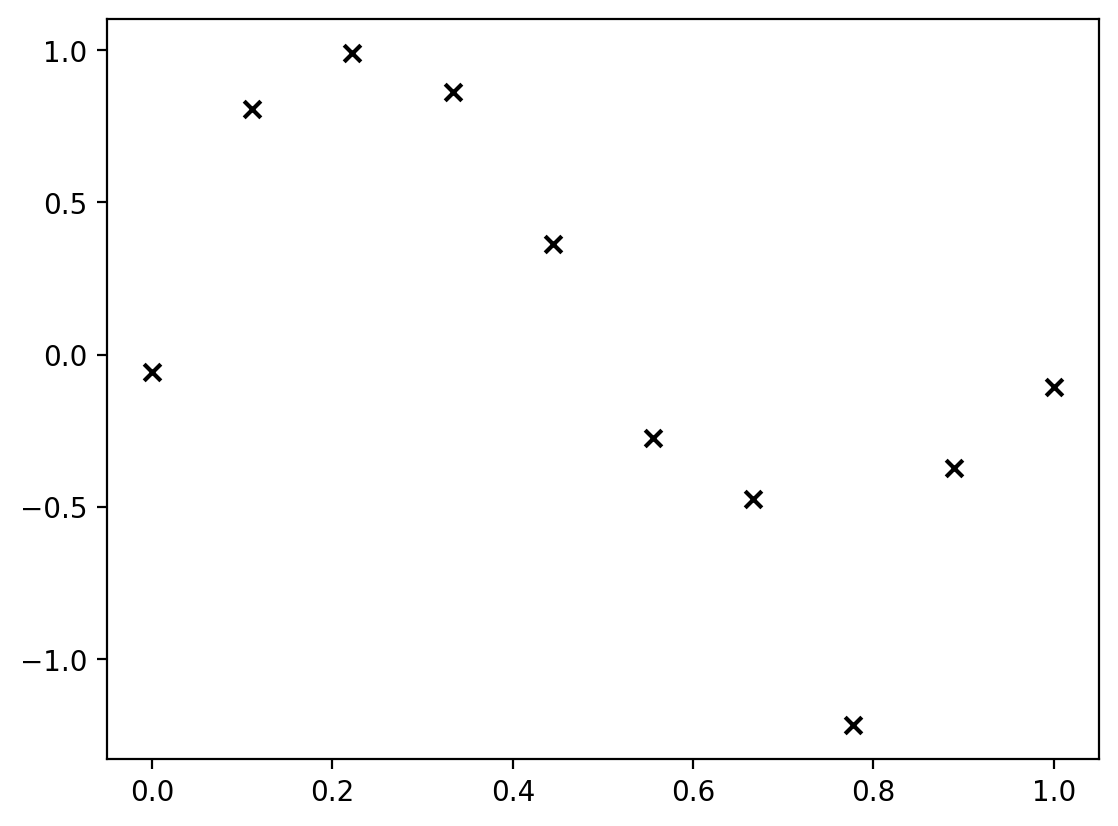

In [62]:
x_train, y_train = generate_toy_data(lambda x: np.sin(2 * np.pi * x), sample_size=10, std=0.25)
plt.scatter(x_train, y_train, marker="x", color="k")
plt.show()

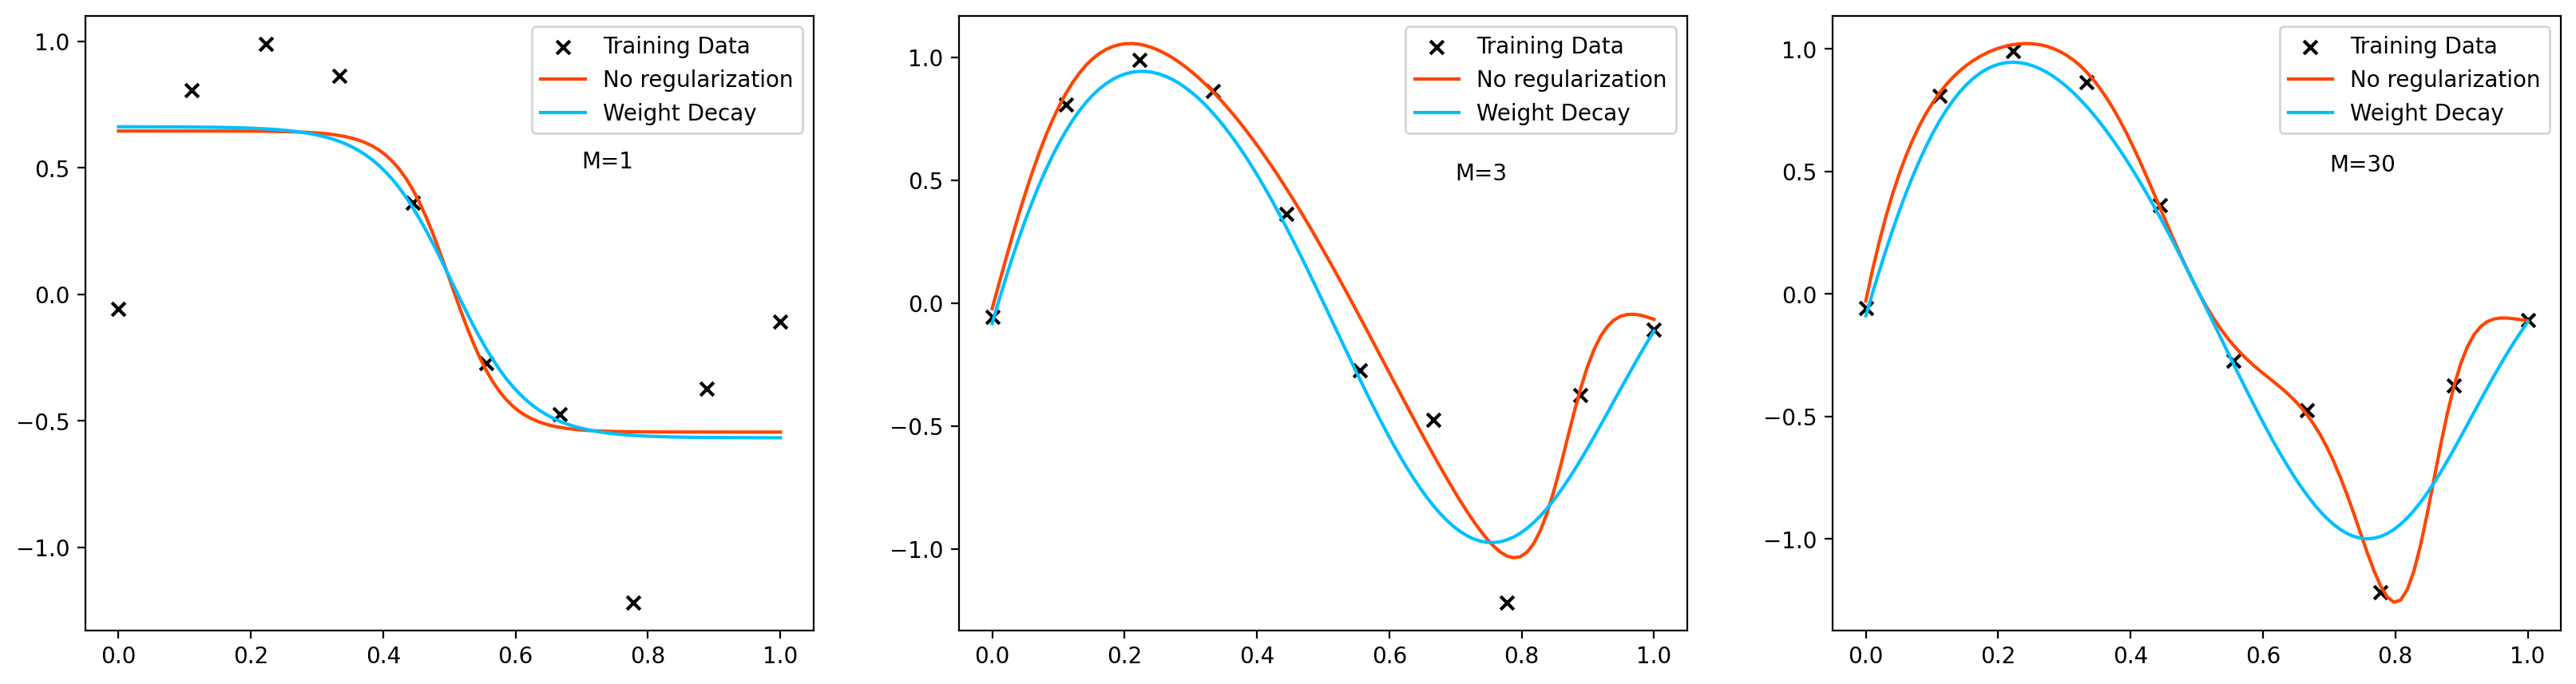

In [64]:
x_space = np.linspace(0, 1, 100)[:, None]

def create_network(m: int) -> nn.NeuralNetwork:
    return nn.NeuralNetwork(
        nn.LinearLayer(1, m),
        nn.TanH(),
        nn.LinearLayer(m, 1),
        nn.Linear(),
    )

plt.figure(figsize=(20, 5))

for i, m in enumerate([1, 3, 30]):
    model = create_network(m)
    model.fit(x_train.reshape(1, -1), y_train, iterations=100000, loss=nn.SSELoss(), optimizer=nn.GradientDescent(learning_rate=0.5), verbose=False)
    y = model(x_space.T)

    regularized_model = create_network(m)
    regularized_model.fit(x_train.reshape(1, -1), y_train, iterations=100000, loss=nn.SSELoss(), optimizer=nn.GradientDescent(learning_rate=0.5, weight_decay=0.0001), verbose=False)
    y_regularized = regularized_model(x_space.T)

    plt.subplot(1, 3, i + 1)
    plt.scatter(x_train.ravel(), y_train.ravel(), marker="x", color="black")
    plt.plot(x_space.ravel(), y.ravel(), color="orangered")
    plt.plot(x_space.ravel(), y_regularized.ravel(), color="deepskyblue")
    plt.annotate(f"M={m}", (0.7, 0.5))
    plt.legend(["Training Data", "No regularization", "Weight Decay"])

plt.show()

### 5.5.1 Consistent Gaussian priors

Simple weight decay is affected by certain scaling properties of network mappings. A regularizer that is invariant to re-scaling of the weights and to shifts to biases, given a $2$-layer neural network is defined as,

$$
\frac{\lambda_1}{2}\sum_{w\in\mathcal{W}_1}w^2 + \frac{\lambda_2}{2}\sum_{w\in\mathcal{W}_2}w^2
$$

where $\mathcal{W}_1$ denotes the weights of the first layer and $\mathcal{W}_2$ denotes the set of weights of the second layer and biases are excluded from the summations. The corresponding Gaussian prior for this regularizer takes the form

$$
p(\mathbf{w}|\alpha_1,\alpha_2) \propto \Big( -\frac{\alpha_1}{2}\sum_{w\in\mathcal{W}_1}w^2 - \frac{\alpha_2}{2}\sum_{w\in\mathcal{W}_2}w^2 \Big)
$$

Note that priors of this form are *improper*, that means they cannot be normalized, because bias parameters are unconstrained. Since improper priors lead to zero evidence in the Bayesian framework, it is common practice to include separate priors for the biases.

In the general case, weights can be divided into any number of groups $\mathcal{W}_k$, thus obtaining priors of the form,

$$
p(\mathbf{w}|\boldsymbol\alpha) \propto \Big( -\frac{1}{2}\sum_{k}\alpha_k ||\mathbf{w}||_k^2 \Big)
$$

where $\boldsymbol\alpha=(\alpha_1,\dots,\alpha_k)$ and $||\mathbf{w}||_k^2 = \sum_{j\in\mathcal{W}_k} w_j^2$.

### 5.5.2 Early stopping

An alternative to regularization is the procedure of *early stopping*. For many algorithms used for network training, such as conjugate gradients, the error is a non-increasing function of the iteration index. However, the error measured on a validation set (independent data), often shows a decrease at first, followed by an increase as the network starts to over-fit. Training can thus be stopped at this point of smallest error with respect to the validation set in order to obtain good generalization performance.

### 5.5.3 Invariances

Ideally, predictions should be unchanged or *invariant* under one or more transformations of the input variables. For example, in image classification tasks, such as digit recognition, the particular object should be assigned the same label irrespective of its position in the image (translation invariance) or of its size (scale invariance). Similar, in speech recognition, small levels of nonlinear warping along the time axis (assuming temporal ordering is perserved) should not change the interpretation of the signal.

Given a sufficiently large number of examples, an adaptive model can learn the invariance, even approximately. However, if the number of examples is limited, or there are several invariants, there is a number of alternative approaches for encouraging a model to exhibit the invariances:

1. Training set can be augmented to include replicas of training examples, transformed according to the desired invariances.
2. A regularization term can be added to the error function to penalize changes in the model output when the input is transformed, a technique called *tangent propagation*.
3. Extracting invariant features, thus building regression or classification systems that necessarily respect the invariances.
4. Build the invariance properties into the structure of the neural network, using local receptive fields and shared weights, such as convolutional neural networks.

### 5.5.6 Convolutional networks
### 5.5.7 Soft weight sharing